## digit recognition model training showing accuracy plots

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import random
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import matplotlib.pyplot as plt
import model

In [2]:
fonts = glob.glob("C:\\Windows\\Fonts" + "\\*.ttf")
def generate_sample_image():
    digit = random.randint(0, 8)
    size = random.randint(200, 240)
    errX = random.randint(-10, 10)
    errY = random.randint(-10, 10)
    y = 128 - size/1.7 + errY
    x = 128 - size/3.5 + errX
    color = 0

    img = Image.new("L", (256, 256), color=255)
    draw = ImageDraw.Draw(img)
    font_face = random.choice(fonts)
    font = ImageFont.truetype(font_face, size)
    draw.text((x, y), str(digit+1), color, font=font)
    img = np.array(img)
    noise = np.random.normal(loc=0, scale=1.8, size=img.shape).astype(np.uint8)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)
    img = Image.fromarray(img)

    img = img.resize((50, 50), Image.BILINEAR)
    img = cv2.threshold(np.asarray(img), 150, 255, cv2.THRESH_BINARY)[1]
    img = cv2.GaussianBlur(img, ksize=(5, 5), sigmaX=0)
    return img, digit

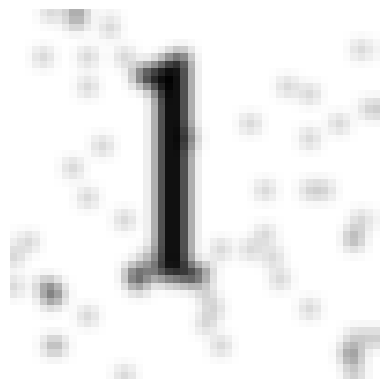

In [3]:
img, dig = generate_sample_image()

image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [4]:
def generate_batch(batch_size):
    X = np.zeros((batch_size, 50, 50))
    Y = []
    for i in range(batch_size):
        image, digit = generate_sample_image()
        image = image / 255
        X[i] = image
        Y.append(digit)
    X = torch.tensor(X).to(torch.float32).reshape(batch_size, -1, 50, 50)
    Y = F.one_hot(torch.tensor(Y), 9)
    return X, Y

In [5]:
myModel = model.Net()

In [6]:
batch_size = 100
lr = 0.001
optimizer = torch.optim.AdamW(myModel.parameters(), lr=lr, eps=1E-8)
criterion = nn.MSELoss()
valLosses = []

for i in range(2500):
    X, Y = generate_batch(batch_size=batch_size)
    
    optimizer.zero_grad()
    Y_hat = myModel(X)

    loss = criterion(Y_hat, Y.to(torch.float32))
    loss.backward()
    optimizer.step()

    if i%10==0:
        valLosses.append(loss.item())
        print(f"{i:04}", ": ", loss.item(), sep="")

0000: 0.24142524600028992
0010: 0.10917961597442627
0020: 0.11000797897577286
0030: 0.11025723069906235
0040: 0.11109547317028046
0050: 0.11110693961381912
0060: 0.11110775917768478
0070: 0.1111082062125206
0080: 0.11110825091600418
0090: 0.11110664159059525
0100: 0.11110220104455948
0110: 0.11110490560531616
0120: 0.11110655963420868
0130: 0.1110987663269043
0140: 0.1110791340470314
0150: 0.11096997559070587
0160: 0.11008398979902267
0170: 0.11096909642219543
0180: 0.10952412337064743
0190: 0.10698720067739487
0200: 0.10247968137264252
0210: 0.09987130016088486
0220: 0.0988573431968689
0230: 0.09712041169404984
0240: 0.09269335120916367
0250: 0.09017918258905411
0260: 0.08366405218839645
0270: 0.0818600282073021
0280: 0.07474415749311447
0290: 0.0768558531999588
0300: 0.0663909912109375
0310: 0.06408432126045227
0320: 0.065776526927948
0330: 0.05128822475671768
0340: 0.05308395251631737
0350: 0.04898592084646225
0360: 0.04126173257827759
0370: 0.03388509899377823
0380: 0.0367996394634

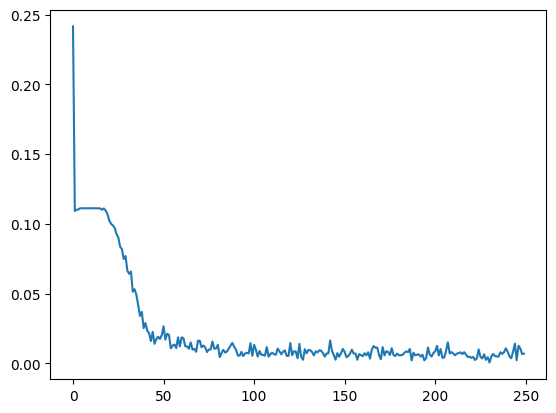

In [7]:
plt.plot(valLosses)
plt.show()

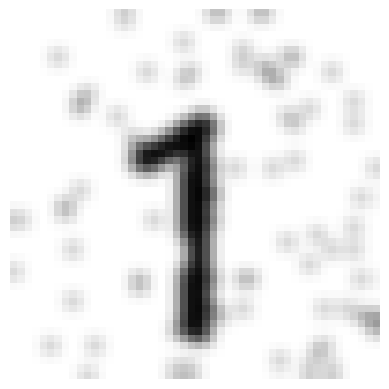

tensor([9.9999e-01, 4.9929e-12, 4.9096e-07, 8.3170e-07, 3.0103e-06, 2.5884e-07,
        3.0477e-05, 2.4607e-13, 1.9900e-07], grad_fn=<SelectBackward0>)


In [8]:
X, Y = generate_batch(1)
image_rgb = cv2.cvtColor(X[0].numpy().reshape(50, 50), cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
print(myModel(X[0])[0])

In [9]:
torch.save(myModel.state_dict(), "model.pth")